# 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

### model import

In [ ]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import pickle
import os
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pandas as pd

## 범석님 감사합니다 🤘

In [ ]:
# %%bash
# apt-get update
# apt-get install g++ openjdk-8-jdk python-dev python3-dev
# pip3 install JPype1
# pip3 install konlpy

In [ ]:
# !echo "$JAVA_HOME"

In [ ]:
# !curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh

In [ ]:
# %%bash
# bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh) 
# pip3 install /tmp/mecab-python-0.996

## 1) 데이터 준비와 확인

작업 순서

1. 데이터셋 다운로드

2. 훈련데이터. 학습데이터 분리 (padding 을 pre로)

3. Validation set 분리

4. 모델 설계

5. 모델 학습 - 체크 포인트 생성

6. 모델 펑가

7. Word2Vec의 적용 - 체크포인트 생성

8. 모델 평가

In [ ]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('/content/drive/MyDrive/Data/002NLP/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/Data/002NLP/sentiment_classification/ratings_test.txt')

train_data.head(20)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


오타가 많음

In [ ]:
print(train_data.shape, test_data.shape)

(150000, 3) (50000, 3)


Train data는 15만개, Test data는 5만개의 데이터가 존재한다.

In [ ]:
train_data.nunique()

id          150000
document    146182
label            2
dtype: int64

In [ ]:
test_data.nunique()

id          50000
document    49157
label           2
dtype: int64

데이터에서 label 의 종류는 0,1 두가지임을 알 수 있다. 

*  긍정적인 리뷰이면 1 
*  부정적인 리뷰이면 0 

으로 분류한것을 확인했다.

데이터에서 id는 중요하지 않으므로 제거할 것이며, label data는 y_train,y_test로 분리할것임.

## 2) 데이터로더 구성

실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와

word_to_index 딕셔너리까지 친절하게 제공합니다. 

그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다.

이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. 

data_loader 안에서는 다음을 수행해야 합니다.

*   데이터의 중복 제거
*   NaN 결측치 제거
*   한국어 토크나이저로 토큰화
*   불용어(Stopwords) 제거
*   사전word_to_index 구성
*   텍스트 스트링을 사전 인덱스 스트링으로 변환
*   X_train, y_train, X_test, y_test, word_to_index 리턴




즉 데이터를 로드하면서 전처리까지 같이 수행하라는 뜻.

## load_data함수 만들기.

In [ ]:
m = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000): ## train,test 데이터와 단어의 개수를 입력으로 받음.
    # 데이터 중복제거
    # inplace = 사용안함.
    train_data.drop_duplicates(['document'],keep='first',inplace = True) 
    test_data.drop_duplicates(['document'],keep='first',inplace = True)
    # NaN 결측치 제거
    train_data = train_data.dropna()
    test_data = test_data.dropna()
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = m.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거 # temp_X에서 가져온 word가 stopwords가 아닐 때 반복.
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = m.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist() 
    counter = Counter(words) # words에서 글자 개수 딕셔너리로 반환.
    counter = counter.most_common(10000-4) # 맨 위 4개 비움 
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

중복제거,및 결측치 제거때 inplace 옵션을 사용하지 않으면 y데이터의 배열 크기가 맞지 않는 문제가 생긴다.

In [ ]:
# load_data실행.    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [ ]:
# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

In [ ]:
index_to_word = {index:word for word, index in word_to_index.items()}

### 피클로 저장.

In [ ]:
#피클로 저장.
import pickle
path_data = '/content/drive/MyDrive/Data/002NLP/sentiment_classification/pickle'

# with open(path_data+'/train.pickle','wb') as a:
#     pickle.dump((X_train, y_train),a)
# with open(path_data+'/test.pickle','wb') as a2:
#     pickle.dump((X_test, y_test),a2)
# with open(path_data+'/word_ind.pickle','wb') as a3:
#     pickle.dump(word_to_index,a3)
# with open(path_data+'/index_wrd.pickle','wb') as a4:
    # pickle.dump(index_to_word,a4)

In [ ]:
with open(path_data+'/train.pickle','rb') as af:
    X_train,y_train = pickle.load(af)
with open(path_data+'/test.pickle','rb') as af2:
    X_test,y_test = pickle.load(af2)
with open(path_data+'/word_ind.pickle','rb') as af3:
    word_to_index = pickle.load(af3)
with open(path_data+'/index_wrd.pickle','rb') as af4:
    index_to_word = pickle.load(af4)

In [ ]:
print(word_to_index['영화'])

5


In [ ]:
print(index_to_word[5])

영화


## Encode, Decode함수 정의

In [ ]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [ ]:
print(index_to_word[0])
print(index_to_word[1]) 
print(index_to_word[2]) 
print(index_to_word[3])
print(index_to_word[4]) 

<PAD>
<BOS>
<UNK>
<UNUSED>
.


In [ ]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


## 3) 모델 구성을 위한 데이터 분석 및 가공



*   데이터셋 내 문장 길이 분포
*   적절한 최대 문장 길이 지정
*   keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가




In [ ]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


---

maxlen을 41로 설정

In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train.copy(),
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=41)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test.copy(),
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=41)

In [ ]:
X_train.shape #ndarray자료형

(146182, 41)

## 4) 모델 구성 및 validation set 구성

146182*0.7 = 102,327

### test , val set 분리

In [ ]:
# validation set 102327건 분리
X_val = X_train[102327:]   
y_val = y_train[102327:]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[:102327]  
partial_y_train = y_train[:102327]

In [ ]:
print(partial_X_train.shape)
print(partial_y_train.shape)
print(X_val.shape)
print(y_val.shape)

(102327, 41)
(102327,)
(43855, 41)
(43855,)


### 모델 설계

### LSTM모델

In [ ]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 시퀀셜 모델링
model = tf.keras.Sequential()

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))) #임베딩 레이어 생성, voab size를 행, word_vector를 열로
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


#### 체크포인트 생성

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Data/002NLP/sentiment_classification/cpt/cp1.ckpt"
checkpoint_dir1 = os.path.dirname(checkpoint_path)

In [ ]:
# 모델의 가중치를 저장하는 콜백 만들기
cp_callback1 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### 1D CNN 모델

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

코드 출처:https://wikidocs.net/80783

In [ ]:
dropout_ratio = 0.3 # 드롭아웃 비율
num_filters = 256 # 커널의 수
kernel_size = 3 # 커널의 크기
hidden_units = 128 # 뉴런의 수
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

checkpoint_path2 = "/content/drive/MyDrive/Data/002NLP/sentiment_classification/cpt/cp2.ckpt"

model2 = Sequential()
model2.add(Embedding(vocab_size, word_vector_dim)) #임베딩 레이어 생성.
model2.add(Dropout(dropout_ratio)) #드롭아웃
model2.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
model2.add(GlobalMaxPooling1D()) # MaxPooling 수행
model2.add(Dense(hidden_units, activation='relu')) # Fully connected Layer
model2.add(Dropout(dropout_ratio)) #드롭아웃
model2.add(Dense(1, activation='sigmoid')) #분류가 1,0 이므로 아웃풋 노드 1, 활성화 함수는 시그모이드.

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3) #얼리스탑 체크포인트
mc = ModelCheckpoint(filepath = checkpoint_path2 , monitor='val_acc', mode='max', verbose=1, save_best_only=True) # 가중치 저장 체크포인트

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history2 = model2.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/20
4559/4569 [============================>.] - ETA: 0s - loss: 0.3924 - acc: 0.8207
Epoch 1: val_acc improved from -inf to 0.87479, saving model to /content/drive/MyDrive/Data/002NLP/sentiment_classification/cpt/cp2.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/002NLP/sentiment_classification/cpt/cp2.ckpt/assets
4569/4569 [==============================] - 20s 4ms/step - loss: 0.3922 - acc: 0.8208 - val_loss: 0.2989 - val_acc: 0.8748
Epoch 2/20
4564/4569 [============================>.] - ETA: 0s - loss: 0.3238 - acc: 0.8621
Epoch 2: val_acc improved from 0.87479 to 0.89278, saving model to /content/drive/MyDrive/Data/002NLP/sentiment_classification/cpt/cp2.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/002NLP/sentiment_classification/cpt/cp2.ckpt/assets
4569/4569 [==============================] - 19s 4ms/step - loss: 0.3237 - acc: 0.8620 - val_loss: 0.2632 - val_acc: 0.8928
Epoch 3/20
4567/4569 [============================>.] - ETA

In [ ]:
results2 = model2.evaluate(X_test,  y_test, verbose=2)

print(results2)

1537/1537 - 3s - loss: 0.3551 - acc: 0.8552 - 3s/epoch - 2ms/step
[0.35514509677886963, 0.8552393317222595]


자체학습시킨 데이터로 정확도 85%를 달성했다.

### DropOut을 제거했을 때 1D CNN모델

In [ ]:
num_filters = 128 # 커널의 수도 줄였다.
kernel_size = 3 # 커널의 크기
hidden_units = 64 # 뉴런의 수도 줄였다.
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 32  # 워드 벡터의 차원 수는 늘렸다.

checkpoint_path3 = "/content/drive/MyDrive/Data/002NLP/sentiment_classification/cpt/cp3.ckpt"

model3 = Sequential()
model3.add(Embedding(vocab_size, word_vector_dim)) #임베딩 레이어 생성.
model3.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
model3.add(GlobalMaxPooling1D()) # MaxPooling 수행
model3.add(Dense(hidden_units, activation='relu')) # Fully connected Layer
model3.add(Dense(1, activation='sigmoid')) #분류가 1,0 이므로 아웃풋 노드 1, 활성화 함수는 시그모이드.

es2 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2) #얼리스탑 체크포인트 patience = 2로 조금 더 빡빡하게 잡았다.
mc2 = ModelCheckpoint(filepath = checkpoint_path2 , monitor='val_acc', mode='max', verbose=1, save_best_only=True) # 가중치 저장 체크포인트

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history3 = model3.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[es2, mc2])

Epoch 1/20
4569/4569 [==============================] - ETA: 0s - loss: 0.3589 - acc: 0.8397
Epoch 1: val_acc improved from -inf to 0.89901, saving model to /content/drive/MyDrive/Data/002NLP/sentiment_classification/cpt/cp3.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/002NLP/sentiment_classification/cpt/cp3.ckpt/assets
4569/4569 [==============================] - 19s 4ms/step - loss: 0.3589 - acc: 0.8397 - val_loss: 0.2558 - val_acc: 0.8990
Epoch 2/20
4556/4569 [============================>.] - ETA: 0s - loss: 0.2685 - acc: 0.8892
Epoch 2: val_acc improved from 0.89901 to 0.92801, saving model to /content/drive/MyDrive/Data/002NLP/sentiment_classification/cpt/cp3.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/002NLP/sentiment_classification/cpt/cp3.ckpt/assets
4569/4569 [==============================] - 19s 4ms/step - loss: 0.2683 - acc: 0.8892 - val_loss: 0.1932 - val_acc: 0.9280
Epoch 3/20
4563/4569 [============================>.] - ETA

In [ ]:
results3 = model3.evaluate(X_test,  y_test, verbose=2)

print(results3)

1537/1537 - 2s - loss: 1.2411 - acc: 0.8329 - 2s/epoch - 2ms/step
[1.241117238998413, 0.8328620791435242]


Validation set의 acc가 높게 나오고, loss도 매우 낮은 값이기에 기대했지만 역시나 오버피팅이었다.

## 5) 모델 훈련 개시

In [ ]:
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

# 새로운 콜백으로 모델 훈련하기
history1 = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[cp_callback1])  # 콜백을 훈련에 전달합니다

# 옵티마이저의 상태를 저장하는 것과 관련되어 경고가 발생할 수 있습니다.
# 이 경고는 (그리고 이 노트북의 다른 비슷한 경고는) 이전 사용 방식을 권장하지 않기 위함이며 무시해도 좋습니다.

Epoch 1/20
199/200 [============================>.] - ETA: 0s - loss: 0.5306 - accuracy: 0.7662
Epoch 1: saving model to /content/drive/MyDrive/Data/002NLP/sentiment_classification/cpt/cp1.ckpt
200/200 [==============================] - 13s 47ms/step - loss: 0.5303 - accuracy: 0.7664 - val_loss: 0.3893 - val_accuracy: 0.8356
Epoch 2/20
200/200 [==============================] - ETA: 0s - loss: 0.3482 - accuracy: 0.8545
Epoch 2: saving model to /content/drive/MyDrive/Data/002NLP/sentiment_classification/cpt/cp1.ckpt
200/200 [==============================] - 10s 48ms/step - loss: 0.3482 - accuracy: 0.8545 - val_loss: 0.3647 - val_accuracy: 0.8398
Epoch 3/20
200/200 [==============================] - ETA: 0s - loss: 0.3176 - accuracy: 0.8679
Epoch 3: saving model to /content/drive/MyDrive/Data/002NLP/sentiment_classification/cpt/cp1.ckpt
200/200 [==============================] - 11s 54ms/step - loss: 0.3176 - accuracy: 0.8679 - val_loss: 0.3549 - val_accuracy: 0.8439
Epoch 4/20
199/200 

In [ ]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 8s - loss: 0.4869 - accuracy: 0.8311 - 8s/epoch - 5ms/step
[0.48687490820884705, 0.8311125636100769]


In [ ]:
# os.listdir(checkpoint_dir1)

['cp1.ckpt.data-00000-of-00001', 'cp1.ckpt.index', 'checkpoint']

In [ ]:
model.load_weights(checkpoint_path)

## 6) Loss, Accuracy 그래프 시각화

### LSTM 모델

In [ ]:
history_dict1 = history1.history
print(history_dict1.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


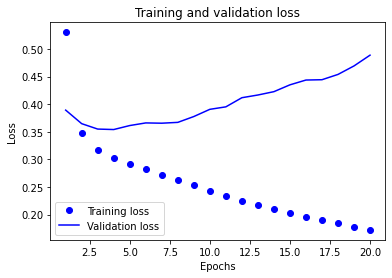

In [ ]:
import matplotlib.pyplot as plt

acc = history_dict1['accuracy']
val_acc = history_dict1['val_accuracy']
loss = history_dict1['loss']
val_loss = history_dict1['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

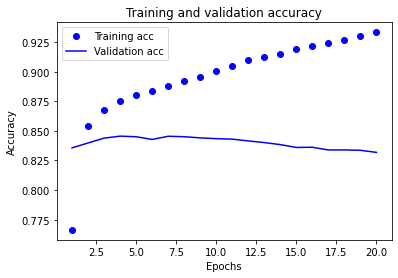

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 1D CNN 모델

In [ ]:
history_dict2 = history2.history
print(history_dict2.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


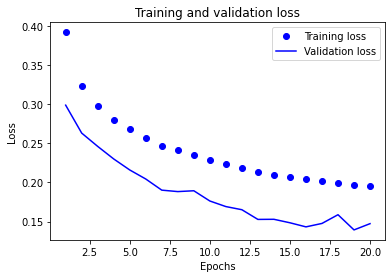

In [ ]:
acc = history_dict2['acc']
val_acc = history_dict2['val_acc']
loss = history_dict2['loss']
val_loss = history_dict2['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

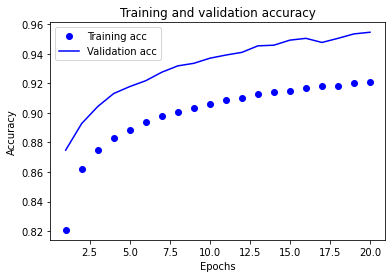

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

모델의 필터 수를 늘린 덕분인지 성능이 매우 좋다.

### DropOut을 제거했을 때 1D CNN모델

In [ ]:
history_dict3 = history3.history
print(history_dict3.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


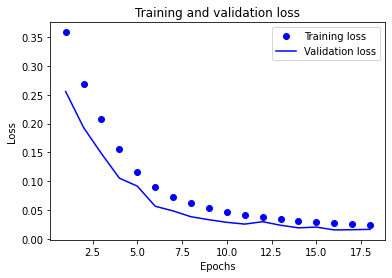

In [ ]:
acc = history_dict3['acc']
val_acc = history_dict3['val_acc']
loss = history_dict3['loss']
val_loss = history_dict3['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

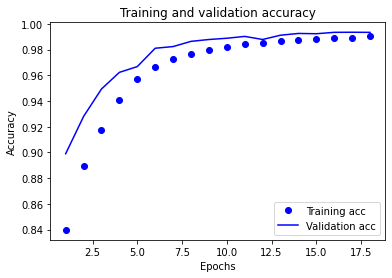

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7) 학습된 Embedding 레이어 분석


### Trouble

현재까지 해결방법을 모름

In [ ]:
# !pip install --upgrade gensim==3.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# !pip --version gensim

In [ ]:
# word2vec_path = '/content/drive/MyDrive/Data/002NLP/word2vec_kor/ko/ko.bin' #용량 큰 버전

# word2vec2 = gensim.models.Word2Vec.load(word2vec_path)

In [ ]:
import gensim
from gensim.models import KeyedVectors

### 용량 작은 버전은 됨

In [ ]:
word2vec_path2 = '/content/drive/MyDrive/Data/002NLP/word2vec_kor/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path2)

In [ ]:
vector2.shape #200dim

(200,)

In [ ]:
vector2 = word2vec['사랑']
vector2 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-1.3740246 , -1.7353463 ,  3.3915305 , -2.569253  , -1.4016607 ,
        1.4556127 ,  0.9414557 ,  1.9207907 ,  0.16471806,  0.4838317 ,
       -0.8547181 ,  2.0879807 ,  0.86741775,  0.87539405, -0.09962013,
        0.22928311, -1.1858722 ,  0.00858838,  1.4999928 , -0.16196461,
       -0.35184434, -0.92390764,  1.0849575 ,  0.3025011 ,  2.7021565 ,
       -1.0263684 ,  0.32864776, -0.76589465, -2.510981  , -0.66225356,
        2.8434615 ,  0.50130975, -1.021874  , -1.4366034 ,  1.1110784 ,
        0.5812605 , -0.5830406 , -0.5785423 ,  1.3634988 ,  2.3074338 ,
       -1.4314893 ,  0.45745876,  1.1073523 , -3.2135262 , -0.2898375 ,
       -1.1622221 ,  1.2369208 , -0.7622987 , -0.37757635,  1.1376442 ,
        0.01065568, -0.69105595,  1.5159112 ,  1.1534518 , -1.0119992 ,
       -0.5757404 ,  1.1349088 , -1.1289831 ,  0.13004152,  2.0451715 ,
       -0.23940353,  1.3604902 ,  0.72700524,  0.32545742,  1.0612459 ,
        0.42252553,  1.1442151 ,  2.8774905 ,  2.4377263 , -1.34

### Embeding 레이어 분석

In [ ]:
word2vec.similar_by_word("사랑")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [ ]:
word2vec.similar_by_word("바보")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('말투', 0.6086437702178955),
 ('괴짜', 0.5944174528121948),
 ('아가씨', 0.592176079750061),
 ('겁쟁이', 0.5897461175918579),
 ('엄마', 0.588951587677002),
 ('외모', 0.5852885246276855),
 ('요괴', 0.5787967443466187),
 ('진짜', 0.5664165019989014),
 ('마녀', 0.5616974830627441),
 ('괴물', 0.5576902627944946)]

말투,괴짜,아가씨,엄마,외모,요괴,진짜,마녀,괴물 등의 단어는 미묘하게 연관성이 있어보이면서도 상관 없는 단어이다.

 데이터가 부족해서 그런 듯 하다.

In [ ]:
word2vec.similar_by_word("이별")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('헤어지', 0.6900225877761841),
 ('슬픔', 0.6873862147331238),
 ('추억', 0.6457439661026001),
 ('슬프', 0.6412862539291382),
 ('재회', 0.6345380544662476),
 ('사랑', 0.6334798336029053),
 ('첫사랑', 0.6128619909286499),
 ('고독', 0.6117805242538452),
 ('절망', 0.5997450947761536),
 ('작별', 0.5857374668121338)]

In [ ]:
word2vec.similar_by_word("스승")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('제자', 0.7363734245300293),
 ('문하생', 0.6908197402954102),
 ('수제자', 0.6906694173812866),
 ('김종직', 0.6722249984741211),
 ('조식', 0.6615128517150879),
 ('서경덕', 0.626617431640625),
 ('심복', 0.62107253074646),
 ('덕행', 0.6179043650627136),
 ('성혼', 0.6100144982337952),
 ('김굉필', 0.6067558526992798)]

김굉필은 문신 조광조의 스승이라한다. 관련이 있어보인다.

성혼은 검색결과 성혼의 아버지가 조광조의 제자였고, 그느 아버지 밑에서 수학했다 한다. 다른 명사일 줄 알았는데 사람 이름이었다.

스승과 관련된 단어들은 대부분 누군가의 스승이었거나 그 스승과 관련된 사람 이름의 비율이 많아보인다. 

아무래도 위키백과같은 곳에서 데이터를 가져와 학습시킨것 같다.

In [ ]:
word2vec.similar_by_word("하늘")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('보름달', 0.5647983551025391),
 ('지옥', 0.5606871843338013),
 ('바다', 0.5598345398902893),
 ('태양', 0.5543240904808044),
 ('저승', 0.5534777641296387),
 ('세상', 0.5530140399932861),
 ('영혼', 0.5516394376754761),
 ('햇살', 0.5444256067276001),
 ('하느님', 0.5399892926216125),
 ('빛', 0.5351409912109375)]

하늘과 관련있는 단어들이 많지만 그 반대인 지옥과 저승이 눈에 띈다.

## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [ ]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)
maxlen = 41
# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
embedding_matrix[1]

array([1.12462889e-01, 1.00094506e-01, 4.87159224e-02, 1.17664618e-01,
       4.45835497e-01, 3.11574285e-01, 6.45626361e-01, 3.25123247e-01,
       5.38004284e-01, 9.15536546e-01, 3.56952456e-01, 8.69858424e-01,
       7.75978924e-01, 3.04942983e-01, 3.97714836e-01, 2.72704378e-01,
       4.11896704e-01, 5.65515576e-01, 9.08786111e-01, 4.85820971e-01,
       7.33138793e-01, 2.84673596e-01, 3.48156260e-01, 6.42418089e-01,
       3.35463026e-01, 1.18270795e-01, 5.77002176e-01, 2.01925199e-02,
       9.30755706e-01, 3.12033687e-01, 1.61844129e-01, 5.40229785e-01,
       1.29958794e-01, 7.90844828e-02, 3.20716895e-01, 3.21839349e-01,
       5.59961232e-01, 5.67139750e-01, 3.36768218e-01, 3.93842605e-01,
       1.69594139e-02, 1.24674500e-01, 8.37484343e-01, 2.21493170e-01,
       7.78260049e-01, 1.29605719e-01, 7.08272996e-01, 5.14044685e-01,
       1.13037270e-01, 8.62334918e-01, 7.67488619e-01, 9.70669903e-01,
       9.27074168e-01, 2.38941197e-01, 6.28339036e-01, 2.85824429e-01,
      

사전학습 된 임베딩 레이어를 가져와 사용

### word2vec으로 임베딩 레이어를 사용한 모델 구성

In [ ]:
from tensorflow.keras.initializers import Constant

코드출처:
https://github.com/alwaysmindy/aiffel_exploration/blob/master/exploration6.ipynb

In [ ]:
# 모델 구성

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 41, 200)           2000000   
                                                                 
 lstm (LSTM)                 (None, 128)               168448    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,185,089
Trainable params: 2,185,089
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 10
model.compile(optimizer='RMSprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_4 = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
200/200 [==============================] - 11s 17ms/step - loss: 0.4878 - accuracy: 0.7597 - val_loss: 0.4185 - val_accuracy: 0.8156
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 0.3614 - accuracy: 0.8398 - val_loss: 0.3491 - val_accuracy: 0.8465
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 0.3146 - accuracy: 0.8636 - val_loss: 0.3381 - val_accuracy: 0.8514
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 0.2825 - accuracy: 0.8801 - val_loss: 0.3265 - val_accuracy: 0.8591
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 0.2564 - accuracy: 0.8928 - val_loss: 0.3210 - val_accuracy: 0.8635
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 0.2318 - accuracy: 0.9041 - val_loss: 0.3495 - val_accuracy: 0.8536
Epoch 7/10
200/200 [==============================] - 3s 13ms/step - loss: 0.2060 - accuracy: 0.9160 - val_loss: 0.3575 - val_accuracy: 0.863

### 정확도 85% 달성

In [ ]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.4354 - accuracy: 0.8567 - 5s/epoch - 3ms/step
[0.4353812336921692, 0.85670405626297]


## 회고

데이터 전처리를 좀 더 잘 수행했다면 어땠을까 하는 마음으로 다른 사람들은 어떻게 전처리를 했는지 찾아보았다.

코드 출처:https://github.com/hjkornn-phys/Aiffel-Exploration-projects/blob/master/Exploration_07/Ex07_Naver_MovieReview_semantic.ipynb

In [ ]:
train_data = pd.read_table('/content/drive/MyDrive/Data/002NLP/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/Data/002NLP/sentiment_classification/ratings_test.txt')

In [ ]:
import re
m = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
def preprocess_review(sentence):
    sentence = re.sub(r'\([^)]*\)',r'',sentence)
    sentence = re.sub(r'\[[^)]*\]',r'',sentence )
    
    sentence = re.sub(r'["."]{2,}', r" '..' ", sentence)
    sentence = re.sub(r'["?"]{2,}', r" ?? ", sentence)
    sentence = re.sub(r'["!"]{2,}', r" !! ", sentence)
    sentence = re.sub(r'["ㅜ"]{2,}', r" ㅜㅜ ", sentence)
    sentence = re.sub(r'["ㅠ"]{2,}', r" ㅠㅠ ", sentence)
    sentence = re.sub(r'["ㅋ"]{2,}', r" ㅋㅋ ", sentence)
    sentence = re.sub(r'["ㅎ"]{2,}', r" ㅎㅎ ", sentence)
    sentence = re.sub(r'["ㄱ"]{2,}', r" ㄱㄱ ", sentence)
    sentence = re.sub(r'["ㄷ"]{2,}', r" ㄷㄷ ", sentence)
    sentence = re.sub(r'["ㅅ"]{2,}', r" ㅅㅅ ", sentence)
    sentence = re.sub(r'["ㅊ"]{2,}', r" ㅊㅊ ", sentence)
    
    sentence = re.sub(r'["ㅈㄴ"]+', "", sentence)
    sentence = re.sub(r'["ㅅㅂ"]+', "", sentence)
    
    sentence = re.sub(r"[^ㄱ-ㅎ|ㅏ-ㅣ|가-힣.?!,' ]+", "", sentence) 
    sentence = re.sub(r'[" "]+', " ", sentence) # 3

    return sentence

In [ ]:
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data['document'] = train_data['document'].apply(lambda x: preprocess_review(str(x)))
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data['document'] = test_data['document'].apply(lambda x: preprocess_review(str(x)))
    test_data = test_data.dropna(how = 'any') 
    
    
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = m.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = m.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [ ]:
X_train, y_train, X_test, y_test, word_dict = load_data(train_data, test_data)

In [ ]:
# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

In [ ]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [ ]:
print(index_to_word[0])
print(index_to_word[1]) 
print(index_to_word[2]) 
print(index_to_word[3])
print(index_to_word[4]) 

<PAD>
<BOS>
<UNK>
<UNUSED>
.


### 비교

**다른 사람의 전처리 후**

In [ ]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

드라마 따라 . . . 다 . . . 했 전개 었 어 쯤
라벨:  0


In [ ]:
print(get_decoded_sentence(X_train[2], index_to_word))
print('라벨: ', y_train[2])

기억 <UNK>
라벨:  0


In [ ]:
print(get_decoded_sentence(X_train[3], index_to_word))
print('라벨: ', y_train[4])

모르 ^^; . . . 다 . . . 눈 보다 좋 하 . . . 다 . . . 평점 공허
라벨:  1


**기존 전처리 후 결과**

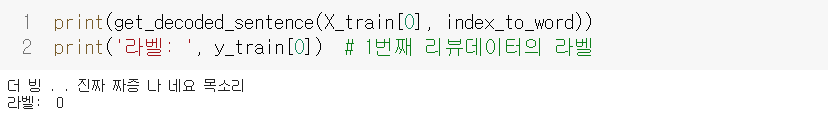

In [ ]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  17.732875048455874
문장길이 최대 :  138
문장길이 표준편차 :  14.463509153450227
pad_sequences maxlen :  46
전체 문장의 0.9371339966403928%가 maxlen 설정값 이내에 포함됩니다. 


**기존 전처리 후 결과**

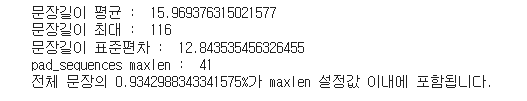

과하게 사라진 데이터도 많고, 문장도 자연스럽지 않아졌다.
 
또한 Maxlen도 기존보다 길어졌다. 저 코드는 안 쓰는게 나아보인다.

### 모델 학습 후기

노드에 있는 LSTM 모델을 가져다 학습시켜보고, 인터넷에서 찾은 조금 더 복잡한 1D CNN 모델을 가져다 

학습시켜본 결과 기존 모델보다 임베딩 벡터를 많이 줄였음에도 불구하고 성능이 단순한 LSTM보다 조금 더 높게 나온점은 신기했다.

반대로 말하면 조금 더 복잡한 모델을 사용하면 더 좋은 결과를 얻을 수 있으리라는 생각이 들었다.

어텐션 메커니즘을 사용한 모델이라면 더 잘 분석할 수 있지 않을까 생각했지만 지금은 잘 모르기 때문에 넘겼다.